# Plot average peri-event per-channel power

Plot power as a function of time surrounding a given event, taken as a median across trials. Also produce plots taking the mean across channels.

In [1]:
import pandas as pd
import numpy as np
import physutils
import dbio
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [2]:
# which patient, dataset to plot
dtup = 18, 1

In [3]:
# set up relevant params
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']  # which bands to limit to
Tpre = -5  # time before event to grab
Tpre_plot = -2.5  # time before event to plot
Tpost = 1.5  # time after event to grab
smwid = 0.2  # smoothing window (in s)

In [4]:
# load data
dbname = os.path.expanduser('data/bart.hdf5')
lfp = dbio.fetch_all_such_LFP(dbname, *dtup)

In [5]:
# remove global mean
if lfp.shape[1] > 1:
    lfp = lfp.demean_global()

In [6]:
# bandpass filter
lfpraw = physutils.LFPset(lfp.copy(), meta=lfp.meta.copy())
if bands:
    if lfp.meta['sr'] < 160:  # that is, if we've not sampled fast enough for gamma
        bands.pop()
    lfp = lfp.bandlimit(bands)

In [7]:
# decimate to 40 Hz
lfp = lfp.decimate(5)
lfpraw = lfpraw.decimate(5)

In [8]:
# instantaneous power
lfp = lfp.instpwr()
lfpraw = lfpraw.instpwr()

In [9]:
# censor
lfp = lfp.censor()
lfpraw = lfpraw.censor()

In [10]:
# get events
evt = dbio.fetch(dbname, 'events', *dtup)
stops = evt['banked'].dropna()
pops = evt['popped'].dropna()
starts = evt['start inflating']
if 'is_control' in evt.columns:
    stops_free = evt.query('is_control == False')['banked'].dropna()
    stops_control = evt.query('is_control == True')['banked'].dropna()
    stops_rewarded = evt.query('trial_type != 4')['banked'].dropna()
    stops_unrewarded = evt.query('trial_type == 4')['banked'].dropna()
else:
    stops_free = stops
    stops_rewarded = stops

In [11]:
def get_peri_event_df(lfp, events, Tpre=Tpre, Tpost=Tpost):
    split = lfp.evtsplit(events, Tpre, Tpost)
    logged = physutils.LFPset(np.log(split), meta=lfp.meta.copy())
    means = logged.groupby(level=1).median()
    df = physutils.LFPset(means, meta=lfp.meta.copy())

    return df.smooth(smwid)

In [12]:
def get_normalizers(df):
    """
    Get robust normalizers for data.
    """
    rstd = lambda x: (x - x.median()).abs().median() * 1.4826
    md = df.median()
    return md, rstd

In [13]:
stop_df = get_peri_event_df(lfp, stops_free)
pop_df = get_peri_event_df(lfp, pops)
raw_stop_df = get_peri_event_df(lfpraw, stops_free)
raw_pop_df = get_peri_event_df(lfpraw, pops)

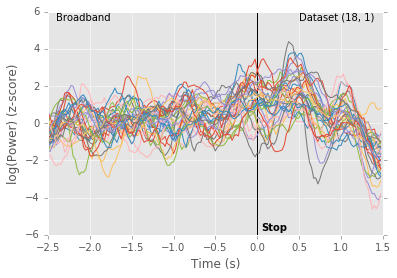

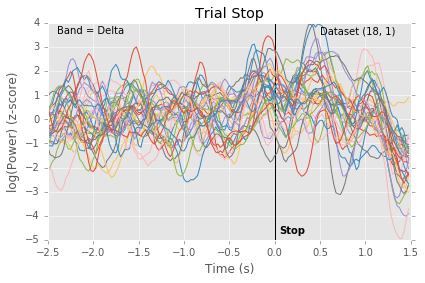

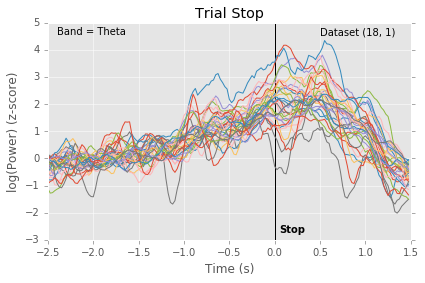

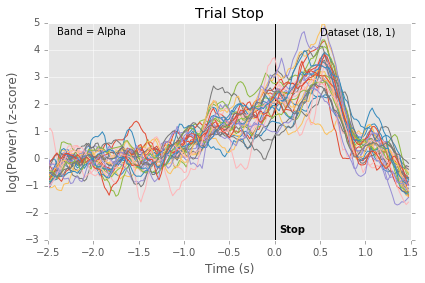

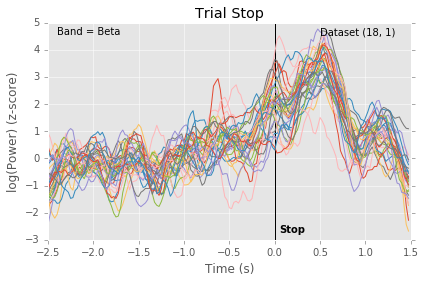

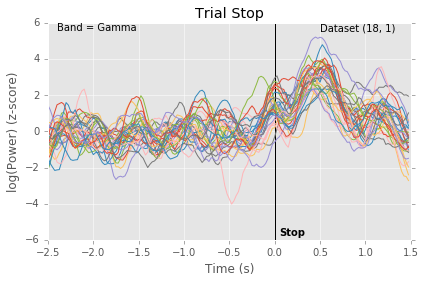

In [14]:
raw_stop_df = raw_stop_df.rzscore()
raw_stop_df.plot(legend=False);
plt.ylabel('log(Power) (z-score)')
plt.xlabel('Time (s)')

stopz = stop_df.rzscore()
raw_stop_df.index.name = 'Time'
plt.xlim([Tpre_plot, Tpost])

# decorations
voffset = -0.45
plt.axvline(x=0, color='k', zorder=1)
plt.text(0.05, plt.ylim()[0] + 0.25, 'Stop', fontweight='bold')
plt.tick_params(axis='x', which='both', top='off');
plt.text(plt.xlim()[1] - 1, plt.ylim()[1] + voffset, "Dataset {}".format(str(dtup)))
plt.text(plt.xlim()[0] + 0.1, plt.ylim()[1] + voffset, "Broadband")

if bands:
    for bb in bands:
        to_grab = [col for col in stopz.columns if bb in col]
        this_df = stopz.loc[:, to_grab]
        this_df.plot(legend=False)
        plt.xlim([Tpre_plot, Tpost])
        
        # decorations
        plt.axvline(x=0, color='k', zorder=1)
        plt.text(0.05, plt.ylim()[0] + 0.25, 'Stop', fontweight='bold')
        plt.tick_params(axis='x', which='both', top='off');
        plt.text(plt.xlim()[1] - 1, plt.ylim()[1] + voffset, "Dataset {}".format(str(dtup)))
        plt.text(plt.xlim()[0] + 0.1, plt.ylim()[1] + voffset, "Band = {}".format(bb.capitalize()))
        
        plt.ylabel('log(Power) (z-score)')
        plt.xlabel('Time (s)')
        plt.title('Trial Stop')
        plt.tight_layout()

        plt.savefig("figures/mean_pwr_all_chans_{}_stop.svg".format(bb))

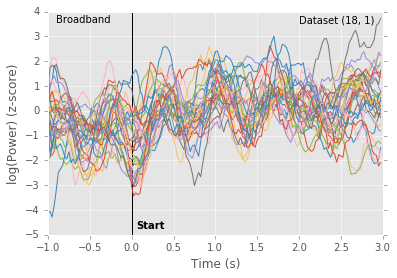

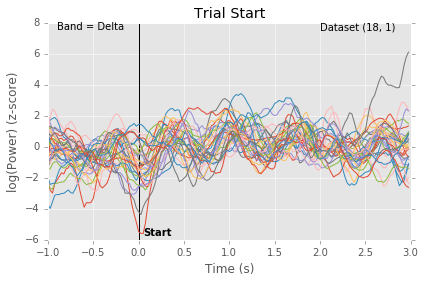

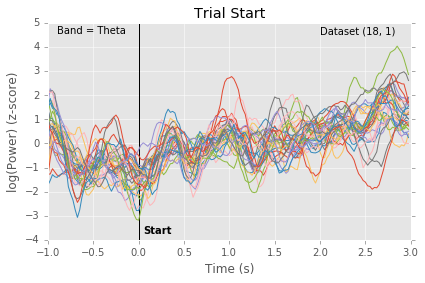

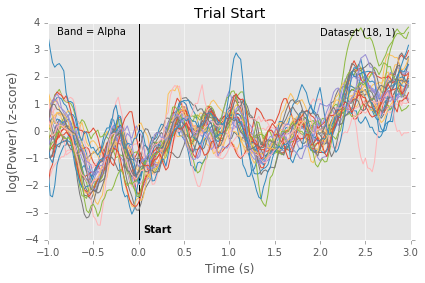

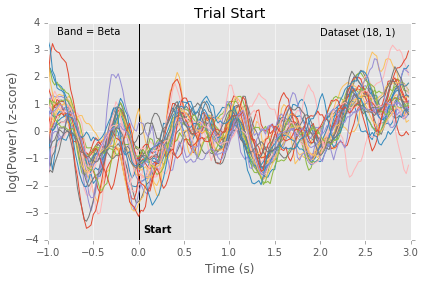

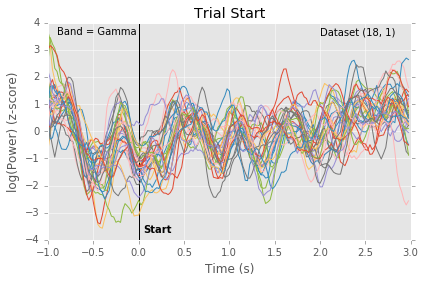

In [15]:
T_pre_start, T_post_start = -1, 3
start_df = get_peri_event_df(lfp, starts, T_pre_start, T_post_start)
raw_start_df = get_peri_event_df(lfpraw, starts, T_pre_start, T_post_start)

raw_start_df = raw_start_df.rzscore()
raw_start_df.plot(legend=False);
plt.ylabel('log(Power) (z-score)')
plt.xlabel('Time (s)')

startz = start_df.rzscore()
raw_start_df.index.name = 'Time'
plt.xlim([T_pre_start, T_post_start])

# decorations
voffset = -0.45
plt.axvline(x=0, color='k', zorder=1)
plt.text(0.05, plt.ylim()[0] + 0.25, 'Start', fontweight='bold')
plt.tick_params(axis='x', which='both', top='off');
plt.text(plt.xlim()[1] - 1, plt.ylim()[1] + voffset, "Dataset {}".format(str(dtup)))
plt.text(plt.xlim()[0] + 0.1, plt.ylim()[1] + voffset, "Broadband")

if bands:
    for bb in bands:
        to_grab = [col for col in startz.columns if bb in col]
        this_df = startz.loc[:, to_grab]
        this_df.plot(legend=False)
        plt.xlim([T_pre_start, T_post_start])
        
        # decorations
        plt.axvline(x=0, color='k', zorder=1)
        plt.text(0.05, plt.ylim()[0] + 0.25, 'Start', fontweight='bold')
        plt.tick_params(axis='x', which='both', top='off');
        plt.text(plt.xlim()[1] - 1, plt.ylim()[1] + voffset, "Dataset {}".format(str(dtup)))
        plt.text(plt.xlim()[0] + 0.1, plt.ylim()[1] + voffset, "Band = {}".format(bb.capitalize()))
        
        plt.ylabel('log(Power) (z-score)')
        plt.xlabel('Time (s)')
        plt.title('Trial Start')
        plt.tight_layout()

        plt.savefig("figures/mean_pwr_all_chans_{}_start.svg".format(bb))

In [16]:
def plot_bands(broad, filtered, legend=True, evt_label='Stop'):
    """
    plot broadband signal and bandpass filtered signal means together
    """
    
    # zscore channels for plotting
    filt = filtered.rzscore()
    broadband_series = broad.rzscore().mean(axis=1)
    
    broadband_series.name = 'Broadband'
    series_list = [broadband_series]
    
    if bands:
        for bb in bands:
            to_grab = [col for col in filt.columns if bb in col]
            this_df = filt.loc[:, to_grab].mean(axis=1)
            this_df.name = bb.capitalize()
            series_list.append(this_df)
    mean_df = pd.concat(series_list, axis=1)
    mean_df.plot(linewidth=2.0, legend=legend);
    plt.xlim([Tpre_plot, Tpost])
    plt.xlabel('Time (s)')
    plt.ylabel('log(Power) (z-score)')
    plt.title("Mean power across channels");

    # decorations
    plt.axvline(x=0, color='k', zorder=1)
    plt.text(0.05, plt.ylim()[0] + 0.25, evt_label, fontweight='bold')
    plt.tick_params(axis='x', which='both', top='off');
    plt.text(plt.xlim()[1] - 1, plt.ylim()[1] - 0.25, "Dataset {}".format(str(dtup)))

    # place the legend to the right of the plot
    ax = plt.gca();
    if legend:
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.2,0.75))
    
    return ax

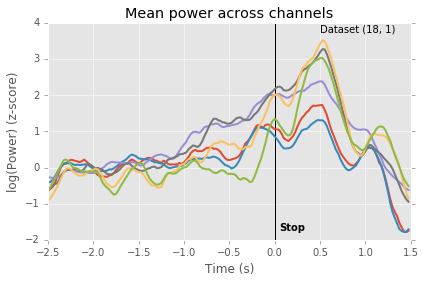

In [17]:
plot_bands(raw_stop_df, stop_df, legend=False);
plt.tight_layout()

plt.savefig("figures/mean_pwr_across_chans.svg")

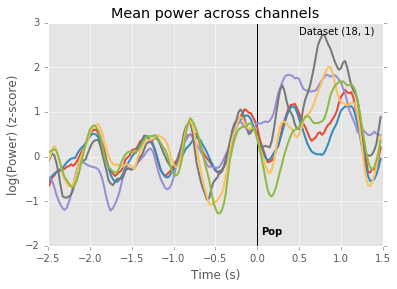

In [18]:
plot_bands(raw_pop_df, pop_df, legend=False, evt_label='Pop');

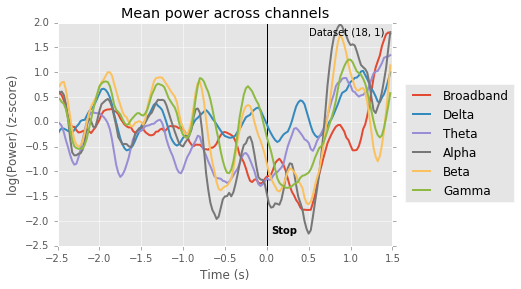

In [19]:
diff_raw = physutils.LFPset(raw_stop_df.dataframe / raw_pop_df.dataframe)
diff_filt = physutils.LFPset(stop_df.dataframe / pop_df.dataframe)
plot_bands(diff_raw, diff_filt);